In [9]:
#setting the end date for analysis
import openpyxl
import os
import win32com.client

date = input("Enter start date for trends DD/MM/YYYY: ")


def ltmexcel(date):
    ltm = openpyxl.load_workbook('SRU2_PI_LTM.xlsx')
    sheet = ltm['Sheet1']
    sheet['A7'] = date
    file = "C:\\Users\\Luke.Popovic\\SRU2_PI_LTM.xlsx"
    ltm.save('SRU2_PI_LTM.xlsx')
    
    xlapp = win32com.client.DispatchEx("Excel.Application")
    wb = xlapp.Workbooks.Open(file)
    xlapp.Visible = True
    wb.RefreshAll()
    wb.Save()
    #here is a critical step, Pi data will need to be refreshed in the 'Calculated Data' tab. Must click apply
    #then save the file
    
    
ltmexcel(date)
               

Enter start date for trends DD/MM/YYYY: 30/03/2020


In [10]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates

#importing LIMS data excel file, excel file is handled better than csv


#this code accepts a tag as a string, plots the excel data as a time series and overlays a monthly average for the 3 month period.
#this file is then saved to month av tag png in C:// drive
# luke popovic 14/03/2020
             

               
def monthav_plot(tag):
    #Cleaning the excel data
    sru2pidf = pd.read_excel('SRU2_PI_LTM.xlsx', skiprows=6).dropna(subset = ['Date'])
    
    cols = [0,1]
    sru2pidf.drop(sru2pidf.columns[cols], axis = 1, inplace=True)
    
    
    #setting the index to date and making this a datetime value
    sru2pidf.set_index('Date', inplace=True)
    
    sru2pidf.index = pd.to_datetime(sru2pidf.index)
    
    
    def units(tag):
        # this function is designed to take the units and description identifiers from the original excel file and allow
        # them to be usable variables for 'description naming' and 'file naming'
        
        #desc is a global variable to allow 2 variables to be generated by the one function, allowing desc to be called in 
        #monthav plot also
        global desc
        sru2rawdf = pd.read_excel('SRU2_PI_LTM.xlsx', skiprows=2)
        sru2rawdf.drop(['Interval', '1h', 'Tag'], axis=1, inplace=True)
        sru2units = sru2rawdf.iloc[0:2,:].T.reset_index()
        sru2units.columns = ['tags','units', 'desc']
        sru2units.set_index('tags', inplace=True)
        unitseries = sru2units.loc[tag]    
        unit = str(unitseries.iloc[0])
        desc = str(unitseries.iloc[1])
        return unit
    
    #unit value is the returned value of the 'tag' function, it gives the units of the pi tag
    unitval = units(tag)
    
    
    t = sru2pidf.index
    s = sru2pidf[tag]
    
    l = t.size
   
    #gets the aveverage value for the month and backfills it into a dataframe
    tstart = t[0]
    tend = t[l-1]
    t1 = pd.Series(0,[tstart])
    t0 = pd.Series(0,[tend])
    #the average value does not backpopulate the 1st of the month so t1 is created to allow bfill to work 
    # to distribute the mean value across the time values from the start to the end of the 3 month period
    #otherwise backfill would stop at the last day of the 1st month in the 3 month sequence 
    month_start = pd.DataFrame(t1)
    month_end = pd.DataFrame(t0)
    
    #resamples the mean for the month and bounds the axes according to the start and end values
    monthlymean = sru2pidf[tag].resample('M').mean()
    monthav = pd.DataFrame(monthlymean).append(month_start)
    monthav.dropna(subset = [tag], inplace=True)
    monthav = pd.DataFrame(monthav).append(month_end).sort_index()

    #drops any rando nan values from the tag column
    monthly = monthav.asfreq('D', method = 'bfill')
    a = monthly[tag]
        
    # create a dataframe, need to fix this to allow for 3-4 months. either create a dataframe with the month name and take the last value or do something else
    mmdf = pd.DataFrame(monthlymean).reset_index()
    mmdf['Month'] = mmdf['Date'].dt.month_name()
    
    #there will always be a minimmum of two months, months 3 and 4 depend on the inital data and whether it crosses 4 months

    count = mmdf['Month'].size

  

    #some weird pandas error told me I need to add this
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
    
    #all of the plotting functions and syntax, note the average calculations and plotting only calculates the average for the number of days
    #that the pi data covers for that month. Ie if it is 30/03/2020 to 30/12/2020 the "December average" will only be the daily average as it is
    #only partly covered. This wasn't considered a big concern as this tool was designed for LTM purposes
    fig, ax = plt.subplots(figsize =(10,10))
    ax.plot(t, s, a)

    title = str("3-month data and monthly average for {} [{}]".format(tag, desc))
    label = str("{} [{}]".format(tag, unitval))
    ax.set_title(title)
    
    
    
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(label)
   
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
    
    m1av = mmdf.at[0, tag]
    m1 = mmdf.at[0, 'Month']
    m2av = mmdf.at[1, tag]
    m2 = mmdf.at[1, 'Month']
    txt1 = str("{} average for {} is {:4.2f} [{}]".format(m1,tag,m1av, unitval))
    txt2 = str("{} average for {} is {:4.2f} [{}]".format(m2,tag,m2av, unitval))
    fig.text(0,0, txt1, fontsize='large')
    fig.text(0,-0.02,txt2, fontsize='large')
    
    if count > 3:
        m3av = mmdf.at[2, tag]
        m3 = mmdf.at[2, 'Month']
        m4av = mmdf.at[3, tag]
        m4 = mmdf.at[3, 'Month']
        txt3 = str("{} average for {} is {:4.2f} [{}]".format(m3,tag, m3av, unitval))
        txt4 = str("{} average for {} is {:4.2f} [{}]".format(m4,tag, m4av, unitval))
        fig.text(0,-0.04, txt3, fontsize='large')
        fig.text(0,-0.06, txt4, fontsize='large')
        mfin = m4
    else: 
        m3av = mmdf.at[2, tag]
        m3 = mmdf.at[2, 'Month']
        txt3 = str("{} average for {} is {:4.2f} [{}]".format(m3,tag, m3av, unitval))
        fig.text(0,-0.04, txt3, fontsize='large')
        mfin = m3
    
    ax.grid()
    
    #file is named based on the tag and the most recent month
    file_name = "{}{}.png".format(tag,mfin)
    
    
    fig.savefig(file_name,  bbox_inches = "tight", pad_inches = 1)
    
    
    plt.show()
    






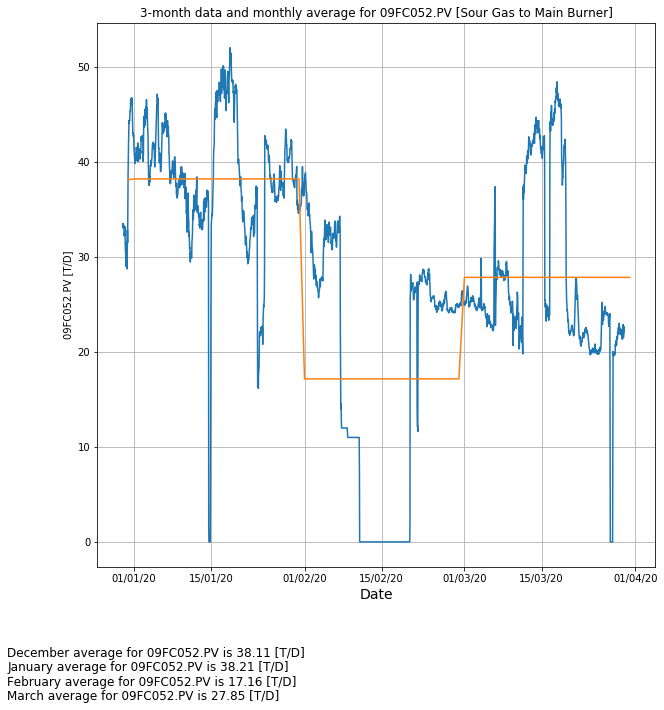

In [11]:
monthav_plot('09FC052.PV')

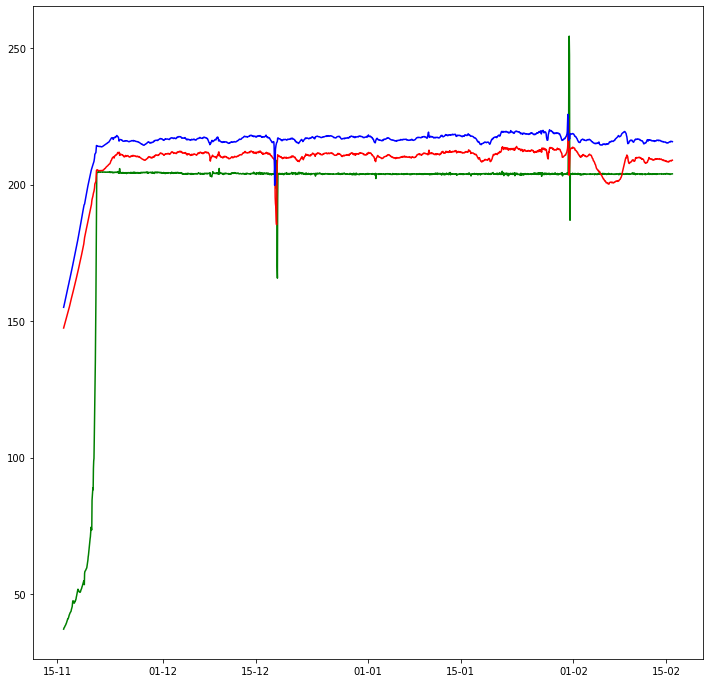

In [51]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates

def exotherm_plot():
    #Cleaning the excel data
    sru2pidf = pd.read_excel('SRU2_PI_LTM.xlsx', skiprows=6).dropna(subset = ['Date'])
    cols = [0,1]
    sru2pidf.drop(sru2pidf.columns[cols], axis = 1, inplace=True)
    
    #setting the index to date and making this a datetime value
    sru2pidf.set_index('Date', inplace=True)
    
    sru2pidf.index = pd.to_datetime(sru2pidf.index)
    srurx = sru2pidf.loc[:,['09TI062.PV','09TI063.PV', '09TI064.PV','09TI065.PV','09TI066.PV', '09TI067.PV']]

    #applying formulas to the srurx 
    srurx['dt1'] = srurx['09TI063.PV'] - srurx['09TI062.PV']
    
    srurx['dt2'] = srurx['09TI064.PV'] - srurx['09TI063.PV']
    srurx['dt_tot'] = srurx['09TI064.PV'] - srurx['09TI062.PV']
    srurx['dt1frac'] = srurx['dt1'] / srurx['dt_tot']
    srurx['dt2frac'] = srurx['dt2'] / srurx['dt_tot']
    
    
    ReactorA = ['09TI062.PV','09TI063.PV', '09TI064.PV']
    ReactorB = ['09TI065.PV','09TI066.PV', '09TI067.PV']
    
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    t = sru2pidf.index
    fig, ax = plt.subplots(figsize = (12,12))
    ax.plot(t,sru2pidf[ReactorB[0]], 'g-', sru2pidf[ReactorB[1]], 'r-', sru2pidf[ReactorB[2]], 'b-' )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    
    plt.show()
exotherm_plot()